In [1]:
import json

import logomaker as lm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyliftover
import seaborn as sns
import seqlogo
from pyfaidx import Fasta
from scipy.stats import chi2_contingency

from analysis_functions import (
                        calculate_chi2_p_values,
                        filter_and_convert_to_list,
                        check_ref,
                        get_codon_position,
                        get_context
                    )

## 1. Separate variants by pathogenicity value

Create dataframes for pathogenic/benign variants based on frequency.

* **pathogenic**  
 Cutoff in AC < 2. Additionally, intersect with the options in ClinVar and add pathogenic/likely pathogenic variants that are missing in GnomAD v.4, but are in ClinVar.

* **benign**  
 AC cut-off >= 2 (according to recent ACGS guidelines, BS2 criterion). In this case, we may have many autosomal recessive variants left, so let’s remove them. To do this, compare the resulting dataframe with benign ClinVar variants and remove all intersections with registered P/LP variants.

In [2]:
nmd_undergo_df = pd.read_csv("data/nmd_undergo_df.csv")

In [3]:
pat_nmd_undergo = nmd_undergo_df.query('AC < 2')

In [4]:
ben_nmd_undergo = nmd_undergo_df.query('AC >= 2')

### Remove all pathogenic Clinvar variants from benign dataframe

Merge `clinvar_nmd_undergo_df` and `ben_nmd_undergo` dataframes, remove all intersections by `CHROM`, `POS`, `REF`, `ALT`, and then remove the remainder of `clinvar_nmd_undergo_df` (i.e. remove all rows that do not have an empty `CLNSIG` column).

In [5]:
clinvar_nmd_undergo_df = pd.read_csv("data/clinvar_nmd_undergo_df.csv")
clinvar_nmd_undergo = clinvar_nmd_undergo_df.rename(columns={'Feature': 'Canonical_transcript'})

In [6]:
merged_clinvar_and_ben_undergo = pd.concat([ben_nmd_undergo, clinvar_nmd_undergo], ignore_index=True)
merged_clinvar_and_ben_undergo

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,...,CLNSIG,CLNVC,GENEINFO,CLNREVSTAT,MC,SYMBOL,Gene,Feature_type,BIOTYPE,CANONICAL
0,chr1,70292486,.,T,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,chr1,70300868,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1131,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chr1,70306276,rs1680585031,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,chr1,70315504,rs1037402044,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,954,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,chr1,93896814,.,G,C,HIGH,stop_gained,GCLM,ENST00000370238,611,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8188,chr22,50721740,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,3958,...,Pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_single_submitter",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8189,chr22,50722004,NaN,G,T,NaN,stop_gained,NaN,ENST00000262795,4222,...,Pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_single_submitter",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8190,chr22,50722235,NaN,C,T,NaN,stop_gained,NaN,ENST00000262795,4453,...,Pathogenic/Likely_pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_multiple_submitters,_no_con...",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES
8191,chr22,50722255,NaN,G,A,NaN,stop_gained,NaN,ENST00000262795,4473,...,Pathogenic,single_nucleotide_variant,SHANK3:85358,"criteria_provided,_single_submitter",SO:0001587|nonsense,SHANK3,ENSG00000251322,Transcript,protein_coding,YES


In [7]:
# remove duplicates
ben_nmd_undergo_filtered = merged_clinvar_and_ben_undergo.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep=False)

In [8]:
# remove the Clinvar df
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[~ben_nmd_undergo_filtered['CLNSIG'].notna()]

In [9]:
ben_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape', 'ID',
       'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC', 'SYMBOL', 'Gene',
       'Feature_type', 'BIOTYPE', 'CANONICAL'],
      dtype='object')

Remove unnecessary columns left after Clinvar.

In [10]:
ben_nmd_undergo_filtered = ben_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'CLNREVSTAT', 'GENEINFO', 'MC', 'SYMBOL', 
                                                'Gene', 'Feature_type', 'BIOTYPE', 'CANONICAL'])
ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,70292486,.,T,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1431,HC,NaN,NaN,4.0,0.248,0.897161,NO
1,chr1,70300868,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1131,HC,NaN,NaN,3.0,0.248,0.897161,NO
2,chr1,70306276,rs1680585031,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1038,HC,NaN,NaN,2.0,0.248,0.897161,NO
3,chr1,70315504,rs1037402044,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,954,HC,NaN,NaN,2.0,0.248,0.897161,NO
4,chr1,93896814,.,G,C,HIGH,stop_gained,GCLM,ENST00000370238,611,HC,NaN,NaN,2.0,0.216,0.650657,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO
3318,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO
3319,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO
3320,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO


Before filtering:

In [11]:
ben_nmd_undergo.shape

(3322, 17)

Add position in codon for each variant.

In [12]:
ben_nmd_undergo_filtered['cDNA_position'] = ben_nmd_undergo_filtered['cDNA_position'].astype(int)

ben_nmd_undergo_filtered['Codon_position'] = np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(ben_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

ben_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,70292486,.,T,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1431,HC,NaN,NaN,4.0,0.248,0.897161,NO,3
1,chr1,70300868,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1131,HC,NaN,NaN,3.0,0.248,0.897161,NO,3
2,chr1,70306276,rs1680585031,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,1038,HC,NaN,NaN,2.0,0.248,0.897161,NO,3
3,chr1,70315504,rs1037402044,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,954,HC,NaN,NaN,2.0,0.248,0.897161,NO,3
4,chr1,93896814,.,G,C,HIGH,stop_gained,GCLM,ENST00000370238,611,HC,NaN,NaN,2.0,0.216,0.650657,NO,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,chr22,50600868,.,C,A,HIGH,stop_gained,MAPK8IP2,ENST00000329492,76,HC,NaN,NaN,2.0,0.100,0.775794,NO,1
3318,chr22,50720238,.,C,A,HIGH,stop_gained,SHANK3,ENST00000262795,2456,HC,NaN,NaN,3.0,0.123,1.000000,NO,2
3319,chr22,50720534,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,2752,HC,NaN,NaN,2.0,0.123,1.000000,NO,1
3320,chr22,50721521,.,G,T,HIGH,stop_gained,SHANK3,ENST00000262795,3739,HC,NaN,NaN,5.0,0.123,1.000000,NO,1


**The dataframe with benign variants is ready.**

### Add all non-population pathogenic Clinvar variants to the pathogenic dataframe

Now add to `pat_nmd_undergo` variants that are P/LP according to ClinVar and are not found in the GnomAD v4 database.

In [13]:
pat_nmd_undergo.shape[0] + clinvar_nmd_undergo.shape[0]

14829

In [14]:
merged_clinvar_and_pat = pat_nmd_undergo.merge(clinvar_nmd_undergo, on=['CHROM', 'POS', 'REF', 'ALT'], how='outer', indicator=True)
merged_clinvar_and_pat

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge
0,chr1,70276794,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,1580.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,chr1,70315510,rs1681037354,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,948.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,chr1,70315540,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,918.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
3,chr1,70324897,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,847.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
4,chr1,71776190,rs1252345844,G,A,HIGH,stop_gained,NEGR1,ENST00000357731,562.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14518,chr9,138120696,NaN,C,T,NaN,NaN,NaN,NaN,NaN,...,ENSG00000148408,Transcript,ENST00000371372,protein_coding,6456.0,YES,0.24,0.97645,NO,right_only
14519,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
14520,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
14521,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


In [15]:
pat_nmd_undergo_filtered = merged_clinvar_and_pat.drop_duplicates(subset=['CHROM', 'POS', 'REF', 'ALT'], keep='first', ignore_index=True)

In [16]:
duplicates = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered.duplicated(subset=['CHROM', 'POS', 'ALT'], keep=False)]
duplicates

,CHROM,POS,rsID,REF,ALT,Impact,Consequence_x,Gene_symbol,Canonical_transcript_x,cDNA_position_x,...,Gene,Feature_type,Canonical_transcript_y,BIOTYPE,cDNA_position_y,CANONICAL,LOEUF_y,pext_y,NMD_escape_y,_merge


In [17]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC',
       'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       'LOEUF_y', 'pext_y', 'NMD_escape_y', '_merge'],
      dtype='object')

In [18]:
pat_nmd_undergo_filtered['Canonical_transcript_x'] = pat_nmd_undergo_filtered['Canonical_transcript_x'].fillna(pat_nmd_undergo_filtered['Canonical_transcript_y'])
pat_nmd_undergo_filtered['cDNA_position_x'] = pat_nmd_undergo_filtered['cDNA_position_x'].fillna(pat_nmd_undergo_filtered['cDNA_position_y'])
pat_nmd_undergo_filtered['Consequence_x'] = pat_nmd_undergo_filtered['Consequence_x'].fillna(pat_nmd_undergo_filtered['Consequence_y'])
pat_nmd_undergo_filtered['LOEUF_x'] = pat_nmd_undergo_filtered['LOEUF_x'].fillna(pat_nmd_undergo_filtered['LOEUF_y'])
pat_nmd_undergo_filtered['Gene_symbol'] = pat_nmd_undergo_filtered['Gene_symbol'].fillna(pat_nmd_undergo_filtered['SYMBOL'])
pat_nmd_undergo_filtered['NMD_escape_x'] = pat_nmd_undergo_filtered['NMD_escape_x'].fillna(pat_nmd_undergo_filtered['NMD_escape_y'])
pat_nmd_undergo_filtered['pext_x'] = pat_nmd_undergo_filtered['pext_x'].fillna(pat_nmd_undergo_filtered['pext_y'])

In [19]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence_x',
       'Gene_symbol', 'Canonical_transcript_x', 'cDNA_position_x', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF_x', 'pext_x', 'NMD_escape_x',
       'ID', 'CLNSIG', 'CLNVC', 'GENEINFO', 'CLNREVSTAT', 'MC',
       'Consequence_y', 'SYMBOL', 'Gene', 'Feature_type',
       'Canonical_transcript_y', 'BIOTYPE', 'cDNA_position_y', 'CANONICAL',
       'LOEUF_y', 'pext_y', 'NMD_escape_y', '_merge'],
      dtype='object')

In [20]:
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.drop(columns=['ID', 'CLNSIG', 'CLNVC', 'CLNREVSTAT', 'GENEINFO', 'MC', 'Consequence_y', 
                                                'SYMBOL', 'Gene', 'Feature_type', 'Canonical_transcript_y', 
                                                'BIOTYPE', 'cDNA_position_y', 'CANONICAL', '_merge', 'LOEUF_y', 'NMD_escape_y', 'pext_y'])

pat_nmd_undergo_filtered = pat_nmd_undergo_filtered.rename(columns={'cDNA_position_x': 'cDNA_position', 
                                                  'Canonical_transcript_x': 'Canonical_transcript', 
                                                  'Consequence_x': 'Consequence', 'LOEUF_x': 'LOEUF', 
                                                  'NMD_escape_x':'NMD_escape', 'pext_x': 'pext'})
pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape
0,chr1,70276794,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,1580.0,HC,NaN,NaN,1.0,0.248,0.897161,NO
1,chr1,70315510,rs1681037354,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,948.0,HC,NaN,NaN,1.0,0.248,0.897161,NO
2,chr1,70315540,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,918.0,HC,NaN,NaN,1.0,0.248,0.897161,NO
3,chr1,70324897,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,847.0,HC,NaN,NaN,1.0,0.248,0.894577,NO
4,chr1,71776190,rs1252345844,G,A,HIGH,stop_gained,NEGR1,ENST00000357731,562.0,HC,NaN,NaN,1.0,0.253,0.997507,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14518,chr9,138120696,NaN,C,T,NaN,stop_gained,CACNA1B,ENST00000371372,6456.0,NaN,NaN,NaN,NaN,0.240,0.976450,NO
14519,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498.0,HC,NaN,NaN,1.0,0.240,0.976450,NO
14520,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525.0,HC,NaN,NaN,1.0,0.240,0.976450,NO
14521,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536.0,HC,NaN,NaN,1.0,0.240,0.976450,NO


In [21]:
pat_nmd_undergo_filtered.columns

Index(['CHROM', 'POS', 'rsID', 'REF', 'ALT', 'Impact', 'Consequence',
       'Gene_symbol', 'Canonical_transcript', 'cDNA_position', 'LoF',
       'LoF_flag', 'LoF_filter', 'AC', 'LOEUF', 'pext', 'NMD_escape'],
      dtype='object')

Before adding Clinvar variants:

In [22]:
pat_nmd_undergo.shape

(9958, 17)

Add position in codon for each variant.

In [23]:
pat_nmd_undergo_filtered['cDNA_position'] = pat_nmd_undergo_filtered['cDNA_position'].astype(int)

pat_nmd_undergo_filtered['Codon_position'] = np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 1, 1,
                                           np.where(pat_nmd_undergo_filtered['cDNA_position'] % 3 == 2, 2, 
                                                    3))

pat_nmd_undergo_filtered

,CHROM,POS,rsID,REF,ALT,Impact,Consequence,Gene_symbol,Canonical_transcript,cDNA_position,LoF,LoF_flag,LoF_filter,AC,LOEUF,pext,NMD_escape,Codon_position
0,chr1,70276794,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,1580,HC,NaN,NaN,1.0,0.248,0.897161,NO,2
1,chr1,70315510,rs1681037354,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,948,HC,NaN,NaN,1.0,0.248,0.897161,NO,3
2,chr1,70315540,.,G,A,HIGH,stop_gained,ANKRD13C,ENST00000370944,918,HC,NaN,NaN,1.0,0.248,0.897161,NO,3
3,chr1,70324897,.,C,T,HIGH,stop_gained,ANKRD13C,ENST00000370944,847,HC,NaN,NaN,1.0,0.248,0.894577,NO,1
4,chr1,71776190,rs1252345844,G,A,HIGH,stop_gained,NEGR1,ENST00000357731,562,HC,NaN,NaN,1.0,0.253,0.997507,NO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14518,chr9,138120696,NaN,C,T,NaN,stop_gained,CACNA1B,ENST00000371372,6456,NaN,NaN,NaN,NaN,0.240,0.976450,NO,3
14519,chr9,138120738,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6498,HC,NaN,NaN,1.0,0.240,0.976450,NO,3
14520,chr9,138120765,.,C,T,HIGH,stop_gained,CACNA1B,ENST00000371372,6525,HC,NaN,NaN,1.0,0.240,0.976450,NO,3
14521,chr9,138120776,.,C,A,HIGH,stop_gained,CACNA1B,ENST00000371372,6536,HC,NaN,NaN,1.0,0.240,0.976450,NO,2


**The dataframe with pathogenic variants is ready.**

## 2. Balance dataframes

In both dataframes, we will leave only those genes that are found in both `ben_nmd_undergo_filtered` and `pat_nmd_undergo_filtered`, and also equalize the number of variants in each gene.

In [24]:
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))


Unique genes in pat dataframe: 1343
Unique genes in ben dataframe: 870
Intersected genes: 852


In [25]:
common_genes = set(unique_genes_ben) & set(unique_genes_pat)

ben_nmd_undergo_filtered = ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]
pat_nmd_undergo_filtered = pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'].isin(common_genes)]

In [26]:
unique_genes_pat = pat_nmd_undergo_filtered['Gene_symbol'].unique()
unique_genes_ben = ben_nmd_undergo_filtered['Gene_symbol'].unique()

intersected_genes = np.intersect1d(unique_genes_pat, unique_genes_ben)

print("Unique genes in pat dataframe:", len(unique_genes_pat))
print("Unique genes in ben dataframe:", len(unique_genes_ben))
print("Intersected genes:", len(intersected_genes))

Unique genes in pat dataframe: 852
Unique genes in ben dataframe: 852
Intersected genes: 852


In [27]:
count_pat = pat_nmd_undergo_filtered['Gene_symbol'].value_counts()
count_ben = ben_nmd_undergo_filtered['Gene_symbol'].value_counts()

min_counts = pd.concat([count_pat, count_ben], axis=1).min(axis=1)

pat_nmd_undergo_final = pd.concat([
    pat_nmd_undergo_filtered[pat_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])

ben_nmd_undergo_final = pd.concat([
    ben_nmd_undergo_filtered[ben_nmd_undergo_filtered['Gene_symbol'] == gene].sample(n=min_count, random_state=42) \
    for gene, min_count in min_counts.items()
])


In [28]:
pat_nmd_undergo_final.shape == ben_nmd_undergo_final.shape

True

In [29]:
pat_nmd_undergo_final['Gene_symbol'].nunique() == ben_nmd_undergo_final['Gene_symbol'].nunique()

True

In [30]:
pat_nmd_undergo_final['Gene_symbol'].value_counts().sum() == ben_nmd_undergo_final['Gene_symbol'].value_counts().sum()

True

In [31]:
pat_nmd_undergo_final['Gene_symbol'].nunique()

852

Dataframes are now balanced by genes and number of variants.

## 3. Get sequence context

Write the context in the corresponding column of the dataframe.

In [32]:
transcript_fasta = Fasta("data_dir/gencode_data/gencode.v45.transcripts.fa.gz", key_function = lambda x: x.split('.')[0])

Get contexts.

In [33]:
get_context(ben_nmd_undergo_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [34]:
get_context(pat_nmd_undergo_final, transcript_fasta, 13, 12)

'Contexts have been added to the dataframe!'

In [35]:
pat_nmd_undergo_final['Strand'] = pat_nmd_undergo_final.apply(check_ref, axis=1, transcript_fasta=transcript_fasta)
pat_nmd_undergo_final['Strand'].value_counts()

Strand
+              1585
-              1435
Not_defined       2
Name: count, dtype: int64

In [36]:
ben_nmd_undergo_final['Strand'] = ben_nmd_undergo_final.apply(check_ref, axis=1, transcript_fasta=transcript_fasta)
ben_nmd_undergo_final['Strand'].value_counts()

Strand
+              1585
-              1436
Not_defined       1
Name: count, dtype: int64

In [37]:
pat_nmd_undergo_final = pat_nmd_undergo_final[pat_nmd_undergo_final['Strand'] != 'Not_defined']
ben_nmd_undergo_final = ben_nmd_undergo_final[ben_nmd_undergo_final['Strand'] != 'Not_defined']

## 4. Get codon positions

In [38]:
pat_nmd_undergo_final['Codon_position'] = pat_nmd_undergo_final.apply(get_codon_position, axis=1)
pat_nmd_undergo_final['Codon_position'].value_counts()

Codon_position
1          1914
3           588
2           517
No_stop       1
Name: count, dtype: int64

In [39]:
ben_nmd_undergo_final['Codon_position'] = ben_nmd_undergo_final.apply(get_codon_position, axis=1)
ben_nmd_undergo_final['Codon_position'].value_counts()

Codon_position
1          2396
3           322
2           301
No_stop       2
Name: count, dtype: int64

In [40]:
pat_nmd_undergo_final = pat_nmd_undergo_final[pat_nmd_undergo_final['Codon_position'] != 'No_stop']
ben_nmd_undergo_final = ben_nmd_undergo_final[ben_nmd_undergo_final['Codon_position'] != 'No_stop']

Divide dataframes depending on codon position.

In [41]:
ben_nmd_undergo_final_1 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 1].copy()
ben_nmd_undergo_final_2 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 2].copy()
ben_nmd_undergo_final_3 = ben_nmd_undergo_final.loc[ben_nmd_undergo_final['Codon_position'] == 3].copy()

In [42]:
pat_nmd_undergo_final_1 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 1].copy()
pat_nmd_undergo_final_2 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 2].copy()
pat_nmd_undergo_final_3 = pat_nmd_undergo_final.loc[pat_nmd_undergo_final['Codon_position'] == 3].copy()

## 5. Visualize the distribution of cDNA positions relative to the transcripts boundaries

Get a dictionary with transcript lengths and write the % location of the variant into a dataframe.

In [43]:
transcript_lengths = {}
for key in transcript_fasta.keys():
    transcript_lengths[key] = len(transcript_fasta[key])

In [44]:
pat_nmd_undergo_final['Percent_position'] = pat_nmd_undergo_final \
    .apply(lambda row: (row['cDNA_position'] / transcript_lengths[row['Canonical_transcript']]) * 100, axis=1)

ben_nmd_undergo_final['Percent_position'] = ben_nmd_undergo_final \
    .apply(lambda row: (row['cDNA_position'] / transcript_lengths[row['Canonical_transcript']]) * 100, axis=1)

Visualize the distribution of variants.

In [45]:
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final.copy()
pat_nmd_undergo_final_sorted['CHROM'] = pat_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
pat_nmd_undergo_final_sorted = pat_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

In [46]:
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final.copy()
ben_nmd_undergo_final_sorted['CHROM'] = ben_nmd_undergo_final_sorted['CHROM'].str.extract(r'(\d+)')
ben_nmd_undergo_final_sorted = ben_nmd_undergo_final_sorted.sort_values(by='CHROM', key=lambda x: x.astype(int))

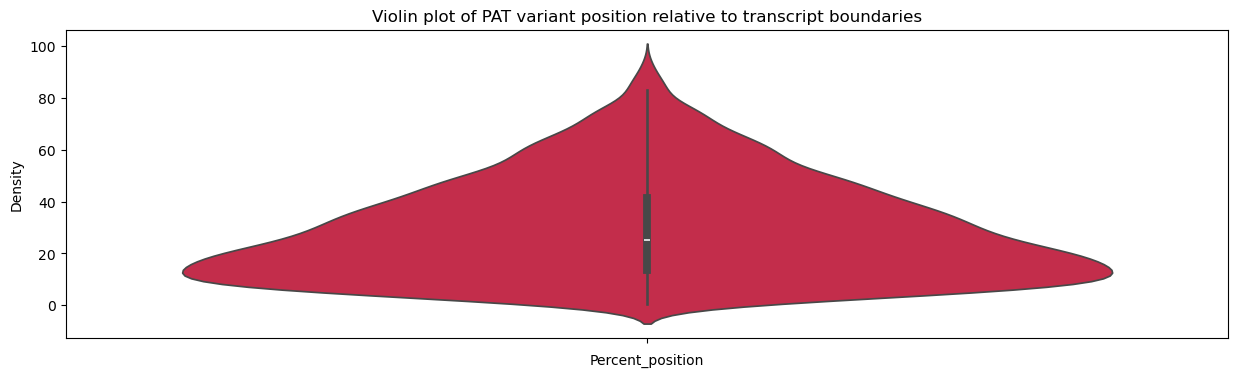

In [47]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=pat_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

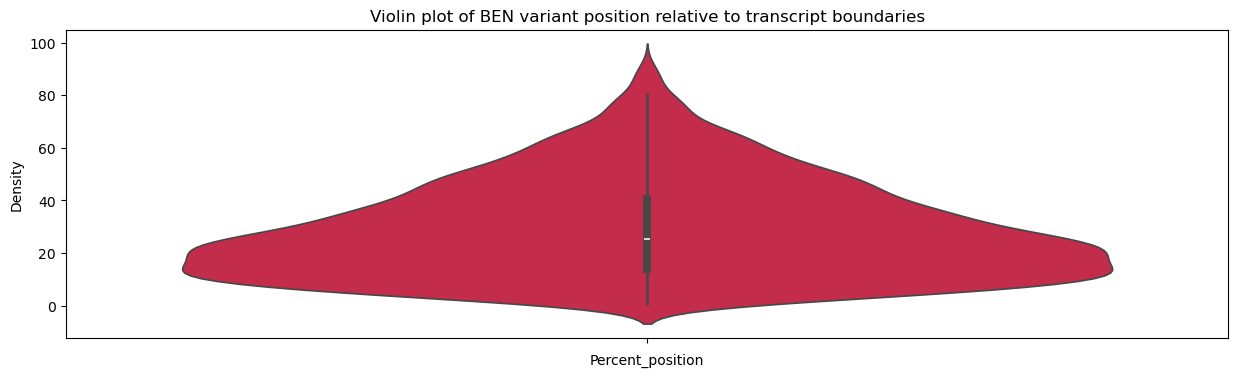

In [48]:
plt.figure(figsize=(15, 4))
sns.violinplot(y='Percent_position', data=ben_nmd_undergo_final_sorted, color='crimson')
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Percent_position')
plt.ylabel('Density')
plt.show()

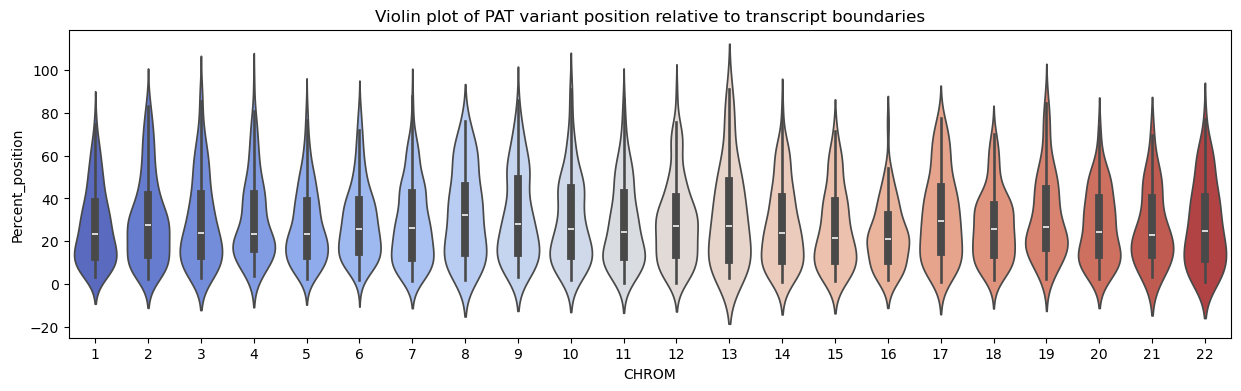

In [49]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

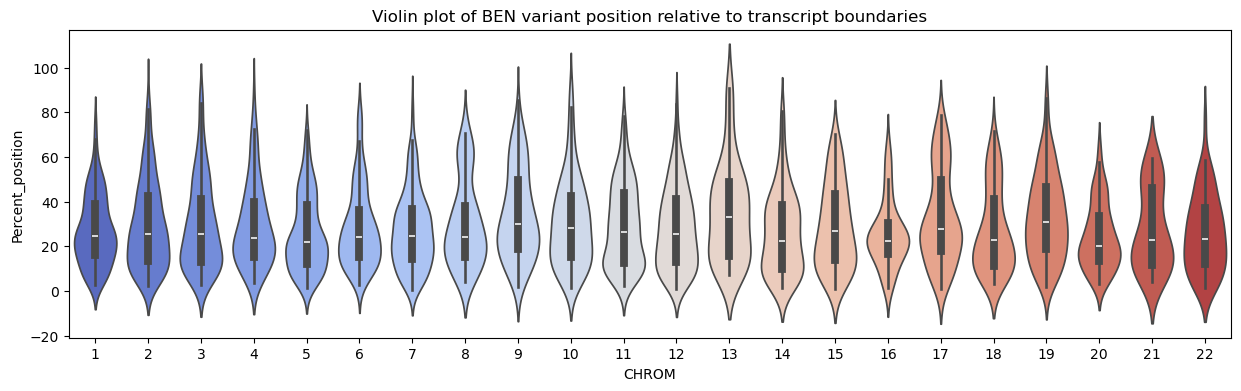

In [50]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='CHROM', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='CHROM', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('CHROM')
plt.ylabel('Percent_position')
plt.show()

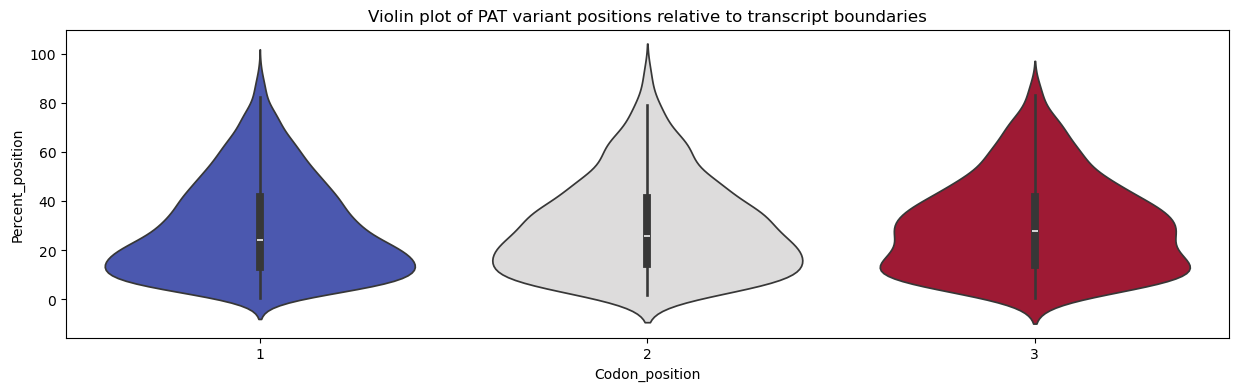

In [51]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=pat_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of PAT variant positions relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

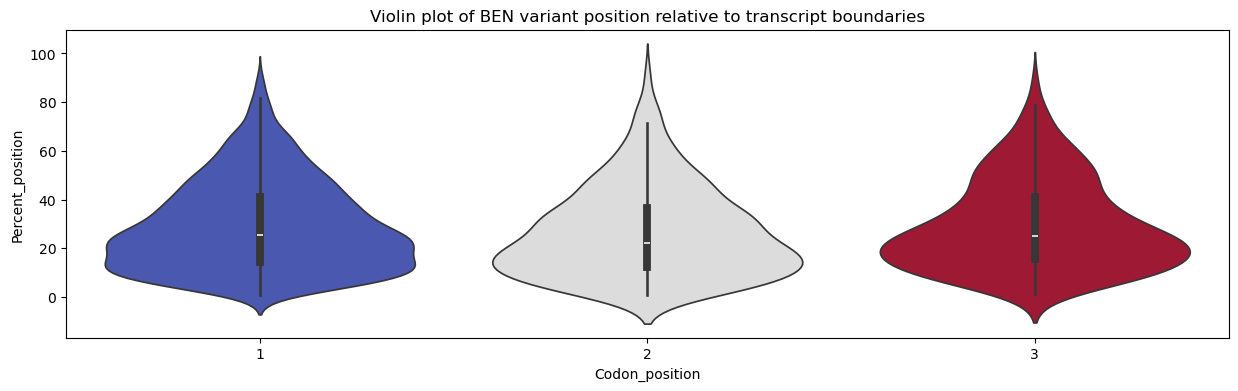

In [52]:
plt.figure(figsize=(15, 4))
sns.violinplot(x='Codon_position', y='Percent_position', data=ben_nmd_undergo_final_sorted, hue='Codon_position', palette='coolwarm', legend=False)
plt.title('Violin plot of BEN variant position relative to transcript boundaries')
plt.xlabel('Codon_position')
plt.ylabel('Percent_position')
plt.show()

## 6. Build a sequence logo

In [53]:
filtered_context_ben_1 = filter_and_convert_to_list(ben_nmd_undergo_final_1['Context'])
filtered_context_ben_2 = filter_and_convert_to_list(ben_nmd_undergo_final_2['Context'])
filtered_context_ben_3 = filter_and_convert_to_list(ben_nmd_undergo_final_3['Context'])

In [54]:
filtered_context_pat_1 = filter_and_convert_to_list(pat_nmd_undergo_final_1['Context'])
filtered_context_pat_2 = filter_and_convert_to_list(pat_nmd_undergo_final_2['Context'])
filtered_context_pat_3 = filter_and_convert_to_list(pat_nmd_undergo_final_3['Context'])

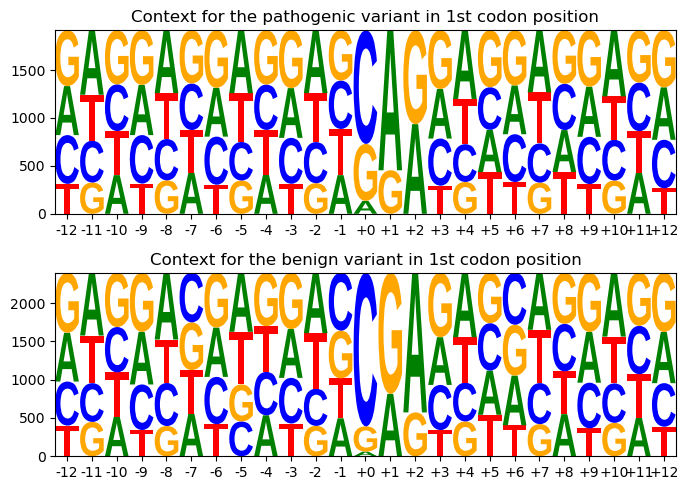

In [55]:
counts_mat_pat_1 = lm.alignment_to_matrix(filtered_context_pat_1)
counts_mat_ben_1 = lm.alignment_to_matrix(filtered_context_ben_1)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_1, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 1st codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_1, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 1st codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/1st_pos_context_nmd_undergo.png', bbox_inches='tight')

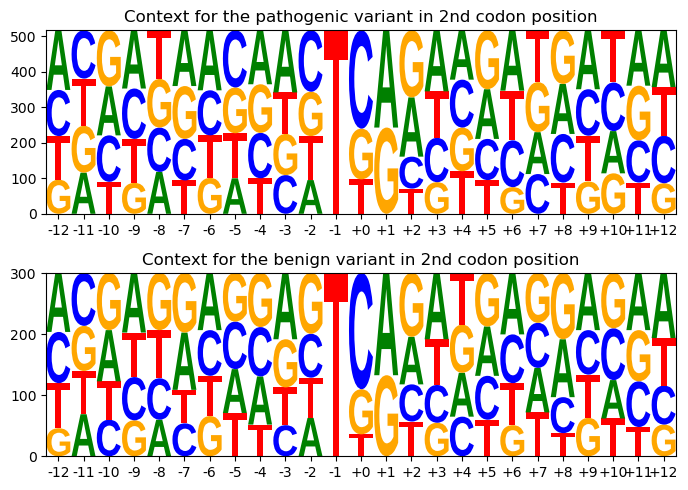

In [56]:
counts_mat_pat_2 = lm.alignment_to_matrix(filtered_context_pat_2)
counts_mat_ben_2 = lm.alignment_to_matrix(filtered_context_ben_2)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_2, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 2nd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_2, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 2nd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/2nd_pos_context_nmd_undergo.png', bbox_inches='tight')

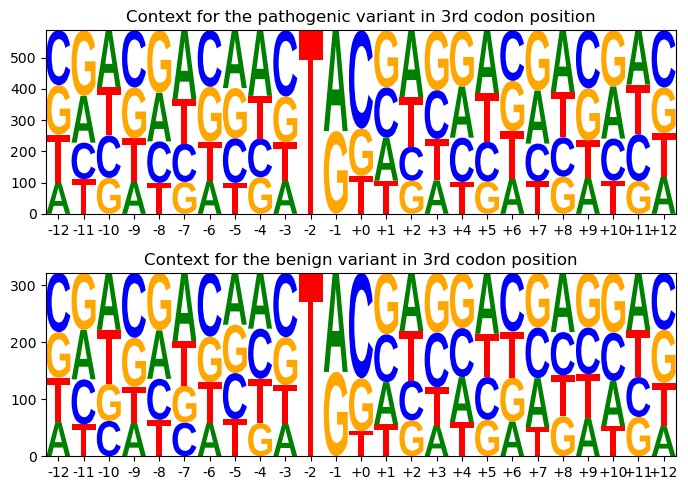

In [57]:
counts_mat_pat_3 = lm.alignment_to_matrix(filtered_context_pat_3)
counts_mat_ben_3 = lm.alignment_to_matrix(filtered_context_ben_3)

fig, axs = plt.subplots(2, 1, figsize=(7, 5))

pat_logo = lm.Logo(counts_mat_pat_3, font_name='Liberation Sans', ax=axs[0])
pat_logo.style_xticks()
pat_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
pat_logo.ax.set_title('Context for the pathogenic variant in 3rd codon position')
pat_logo.draw()

ben_logo = lm.Logo(counts_mat_ben_3, font_name='Liberation Sans', ax=axs[1])
ben_logo.style_xticks()
ben_logo.ax.set_xticklabels('%+d'%x for x in range(-12, 13))
ben_logo.ax.set_title('Context for the benign variant in 3rd codon position')
ben_logo.draw()

plt.tight_layout()
plt.savefig('images/3rd_pos_context_nmd_undergo.png', bbox_inches='tight')

## 7. Statistical comparison of positions in contexts

Calculate chi-squares for each position when comparing two matrices (for pathogenic and benign contexts).

In [58]:
chi2_values_1, p_values_1 = calculate_chi2_p_values(filtered_context_ben_1, filtered_context_pat_1)

for i, (chi2, p_value) in enumerate(zip(chi2_values_1, p_values_1)):
    print(f"Position {i + 1}: Chi-square = {chi2}, p-value = {p_value}")

Position 1: Chi-square = 4.710347784069416, p-value = 0.5396605203445339
Position 2: Chi-square = 3.6558289775616175, p-value = 0.5790516494416388
Position 3: Chi-square = 0.36132404192231193, p-value = 1.0
Position 4: Chi-square = 6.933022377258824, p-value = 0.3085978962702036
Position 5: Chi-square = 4.417299824198587, p-value = 0.5494666066857171
Position 6: Chi-square = 5.0530233724479965, p-value = 0.5396605203445339
Position 7: Chi-square = 2.6446255655340365, p-value = 0.7495329398841265
Position 8: Chi-square = 7.635420436288429, p-value = 0.3085978962702036
Position 9: Chi-square = 1.249778484887495, p-value = 0.9263647182877804
Position 10: Chi-square = 1.775041105708668, p-value = 0.8199754456755202
Position 11: Chi-square = 7.748833305723751, p-value = 0.3085978962702036
Position 12: Chi-square = 15.654696366463067, p-value = 0.03336562764296121
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = nan, p-value = 1.0
Position 15: Chi-square = nan, p-value 

In [59]:
chi2_values_2, p_values_2 = calculate_chi2_p_values(filtered_context_ben_2, filtered_context_pat_2)
for i, (chi2, p_value) in enumerate(zip(chi2_values_2, p_values_2)):
    print(f"Position {i + 1}: Chi-square = {chi2}, p-value = {p_value}")

Position 1: Chi-square = 1.7922353946585328, p-value = 0.9429728830047445
Position 2: Chi-square = 0.9071704728509863, p-value = 0.9863862451694649
Position 3: Chi-square = 3.7728758765622556, p-value = 0.9429728830047445
Position 4: Chi-square = 1.9659333557078216, p-value = 0.9429728830047445
Position 5: Chi-square = 2.44530532868524, p-value = 0.9429728830047445
Position 6: Chi-square = 2.929267566450526, p-value = 0.9429728830047445
Position 7: Chi-square = 0.8062635183310696, p-value = 0.9863862451694649
Position 8: Chi-square = 3.947394541831436, p-value = 0.9429728830047445
Position 9: Chi-square = 2.101052289675014, p-value = 0.9429728830047445
Position 10: Chi-square = 3.489628814309651, p-value = 0.9429728830047445
Position 11: Chi-square = 12.430881366224625, p-value = 0.13873051759630897
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = nan, p-value = 1.0
Position 15: Chi-square = 6.874029191575037, p-value =

In [60]:
chi2_values_3, p_values_3 = calculate_chi2_p_values(filtered_context_ben_3, filtered_context_pat_3)
for i, (chi2, p_value) in enumerate(zip(chi2_values_3, p_values_3)):
    print(f"Position {i + 1}: Chi-square = {chi2}, p-value = {p_value}")

Position 1: Chi-square = 1.460658643710065, p-value = 0.9266961682121961
Position 2: Chi-square = 3.8339543241452163, p-value = 0.9266961682121961
Position 3: Chi-square = 2.311814434120297, p-value = 0.9266961682121961
Position 4: Chi-square = 3.0387092867917476, p-value = 0.9266961682121961
Position 5: Chi-square = 1.5211585728821282, p-value = 0.9266961682121961
Position 6: Chi-square = 1.62088557365775, p-value = 0.9266961682121961
Position 7: Chi-square = 3.0102792351905565, p-value = 0.9266961682121961
Position 8: Chi-square = 2.1319806724732393, p-value = 0.9266961682121961
Position 9: Chi-square = 5.6516595621697805, p-value = 0.9266961682121961
Position 10: Chi-square = 0.15357247422464843, p-value = 1.0
Position 11: Chi-square = nan, p-value = 1.0
Position 12: Chi-square = nan, p-value = 1.0
Position 13: Chi-square = nan, p-value = 1.0
Position 14: Chi-square = 0.5783179079155266, p-value = 1.0
Position 15: Chi-square = 2.6827899486770934, p-value = 0.9266961682121961
Positio

In [61]:
positions_list = [list(range(-12, 13)), list(range(-12, 13)), list(range(-12, 13))]
p_values_list = [p_values_1, p_values_2, p_values_3]

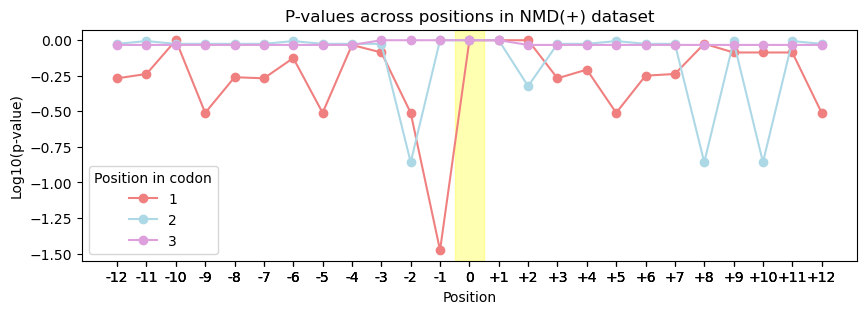

In [62]:
plt.figure(figsize=(10, 3))
#colors = ['#C8A2C8', '#B0E0E6', '#FFB6C1']
colors = ['lightcoral', 'lightblue', 'plum']

for positions, p_values, color in zip(positions_list, p_values_list, colors):
    plt.plot(positions, np.log10(p_values), marker='o', linestyle='-', color=color)

plt.title('P-values across positions in NMD(+) dataset')
plt.xlabel('Position')
plt.ylabel('Log10(p-value)')
plt.grid(False)
plt.legend(['1', '2', '3'], title='Position in codon')

all_positions = [pos for sublist in positions_list for pos in sublist]
plt.xticks(all_positions, [str(pos) if pos == 0 else f"{pos}" if pos < 0 else f"+{pos}" for pos in all_positions])

plt.axvspan(-0.5, 0.5, color='yellow', alpha=0.3)

plt.savefig('images/p_values_nmd_undergo_plot.png')
plt.show()

## 8. Relationship between the significance of a variant and its position in a codon¶

In [63]:
pat_nmd_undergo_final.loc[:, 'Significance'] = 'pathogenic'
ben_nmd_undergo_final.loc[:, 'Significance'] = 'benign'

In [64]:
all_nmd_undergo_final = pd.concat([pat_nmd_undergo_final, ben_nmd_undergo_final], ignore_index=True)

In [65]:
all_nmd_undergo_final = all_nmd_undergo_final.loc[all_nmd_undergo_final['Codon_position'] != 'No_stop']

In [66]:
all_nmd_undergo_final.to_csv('data/all_nmd_undergo_final.csv', index=False)

In [67]:
cross_tab_undergo = pd.crosstab(all_nmd_undergo_final['Significance'], all_nmd_undergo_final['Codon_position'])
print(cross_tab_undergo)

Codon_position     1    2    3
Significance                  
benign          2396  301  322
pathogenic      1914  517  588


In [68]:
chi2_undergo, p_value_undergo, _, _ = chi2_contingency(cross_tab_undergo)
print(f"Chi-squared value: {chi2_undergo}")
print(f"P-value: {p_value_undergo}")

Chi-squared value: 188.69400124889435
P-value: 1.0607627112644758e-41


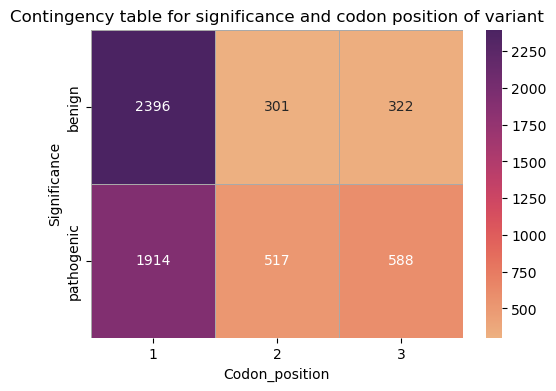

In [69]:
plt.figure(figsize=(6, 4))
sns.heatmap(cross_tab_undergo, annot=True, cmap='flare', fmt='d', cbar=True, linewidths=0.5, linecolor='darkgrey')
plt.title('Contingency table for significance and codon position of variant')
plt.xlabel('Codon_position')
plt.ylabel('Significance')
plt.show()


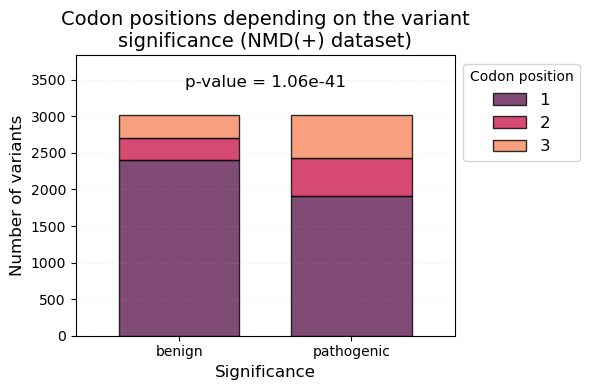

In [74]:
palette = sns.color_palette("rocket", len(cross_tab_undergo.columns))

ax = cross_tab_undergo.plot(kind='bar', stacked=True, alpha=0.8, edgecolor='black', linewidth=1, width=0.7, color=palette, figsize=(6, 4))

plt.title('Codon positions depending on the variant\nsignificance (NMD(+) dataset)', fontsize=14)
plt.xlabel('Significance', fontsize=12)
plt.ylabel('Number of variants', fontsize=12)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Codon position', fontsize=12, bbox_to_anchor=(1, 1), loc='upper left')
plt.ylim(top=cross_tab_undergo.max().max() * 1.6)
plt.text(0.5, 3400, f'p-value = {format(p_value_undergo, '.2e')}', fontsize=12, ha='center')
plt.grid(True, axis='y', linestyle='--', alpha=0.1)
plt.tight_layout()

plt.savefig('images/codon_positions_hist_undergo.png', dpi=300)

plt.show()